In [1]:
import numpy as np
from data.MyDataSet import MyDataSet
from unet.unet_model import UNet
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import gc

### Start Plot Server, Do not run this command at here

In [2]:
# !python -m visdom.server

In [2]:
def train_net(net, device, train_loader, optimizer, epochIdx, criterion, ACC_LIST, LOSS_LIST):
    net.train()
    train_loss = 0
    correct = 0
    i = 0
    for batch_idx, (image, target) in enumerate(train_loader):
        image, target = image.to(device=device, dtype=torch.float32), target.to(device=device, dtype=torch.float32)
        optimizer.zero_grad()
        # predict the output
        output = net(image)

        # calculate the loss
        loss = criterion(output, target)
        train_loss += loss
        LOSS_LIST.append(loss.item())

        # calculate accuracy
        acc = cal_acc(output, target)
        correct += acc
        ACC_LIST.append(acc.item())


        # back forward to update parameters
        loss.backward()
        optimizer.step()

        i = batch_idx
    
    print('\n Epoch {:d} Train set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(epochIdx, train_loss / i, correct / i))

def eval_net(net, device, validate_loader, epochIdx, criterion, ACC_LIST, LOSS_LIST):
    net.eval()
    validate_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():
        for batch_idx, (image, target) in enumerate(validate_loader):
            image, target = image.to(device=device, dtype=torch.float32), target.to(device=device, dtype=torch.float32)

            # predict the mask
            output = net(image)

            # calculate the loss
            loss = criterion(output, target)
            validate_loss += loss
            LOSS_LIST.append(loss.item())
            
            # calculate accuracy
            acc = cal_acc(output, target)
            correct += acc
            ACC_LIST.append(acc.item())

            i = batch_idx
            
        print('\nEpoch {:d} Validate set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(epochIdx, validate_loss / i, correct / i))
       
"""
    # calculate accuracy
    acc = cal_acc(output, target)
    ACC_LIST.append(acc)
    # print("Acc: ", acc)
"""
def cal_acc(pred, label):
    _, tags = torch.max(pred, dim = 1)
    corrects = (tags == label).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    return acc

In [3]:
gc.collect()
torch.cuda.empty_cache()
# prepare data set
trainSet = MyDataSet("./data/SDLane/train/", "./data/SDLane/train/train_list.txt")

train_set_size = 30000
valid_set_size = 9096

trainSet, validateSet = torch.utils.data.random_split(trainSet, [train_set_size, valid_set_size])

train_loader = DataLoader(dataset=trainSet, batch_size=10, shuffle=True)
validate_loader = DataLoader(dataset=validateSet, batch_size=10, shuffle=True)


In [4]:
# prepare net parameters
EPOCHS = 2
net = UNet(n_channels=1, n_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
# optimizer and loss function
optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

# train network
TRAIN_ACC_LIST = []
TRAIN_LOSS_LIST = []

VALIDATE_ACC_LIST = []
VALIDATE_LOSS_LIST = []

for epoch in range(1, EPOCHS + 1):
    train_net(net, device, train_loader, optimizer, epoch, criterion, TRAIN_ACC_LIST, TRAIN_LOSS_LIST)
    eval_net(net, device, validate_loader, epoch, criterion, VALIDATE_ACC_LIST, VALIDATE_LOSS_LIST)

torch.save(net, "./model.mod")


 Epoch 1 Train set: Average loss: 0.0410, Accuracy: (97%)


Epoch 1 Validate set: Average loss: 0.0320, Accuracy: (97%)


 Epoch 2 Train set: Average loss: 0.0273, Accuracy: (97%)


Epoch 2 Validate set: Average loss: 0.0266, Accuracy: (97%)



### Save record: Loss & accuracy

In [14]:
import csv
with open('./trainRecord.csv','w') as f1:
    writer=csv.writer(f1, delimiter='\t',lineterminator='\n',)
    row = "{}, {}, {}".format("index", "accuracy", "loss")
    writer.writerow(row)
    for i in range(len(TRAIN_ACC_LIST)):
        row = "{}, {}, {}".format(i, TRAIN_ACC_LIST[i], TRAIN_LOSS_LIST[i])
        writer.writerow(row)

with open('./validateRecord.csv','w') as f2:
    writer=csv.writer(f2, delimiter='\t',lineterminator='\n',)
    row = "{}, {}, {}".format("index", "accuracy", "loss")
    writer.writerow(row)
    for i in range(len(VALIDATE_ACC_LIST)):
        row = "{}, {}, {}".format(i, VALIDATE_ACC_LIST[i], VALIDATE_LOSS_LIST[i])
        writer.writerow(row)

## Plot show the Loss

In [15]:
import matplotlib.pyplot as plt
trainIndexes = []
for i in range(len(TRAIN_ACC_LIST)):
    trainIndexes.append(i)

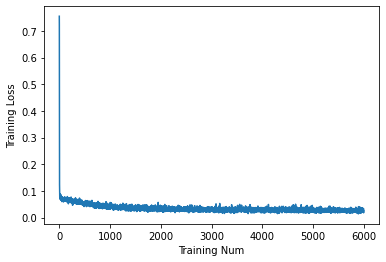

In [7]:
plt.xlabel("Training Num")
plt.ylabel("Training Loss")
plt.plot(trainIndexes, TRAIN_LOSS_LIST)